In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import learning_curve
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Define the Main Class
class CreditCardFraudDetectionLR:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.model = None
        self.results = {}
        self.best_params = {}
        self.data_loaded = False
        
    def create_directories(self):
        """Create necessary directories for saving plots"""
        os.makedirs('../img/logistic-regression/', exist_ok=True)
        print("Created directories for saving plots")
        
    def load_data(self):
        """Load and preprocess the credit card fraud dataset with multiple fallbacks"""
        print("Loading dataset...")
        
        # Try multiple URLs and methods
        urls = [
            "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv",
            "https://media.githubusercontent.com/media/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
        ]
        
        # Try direct pandas read first
        for url in urls:
            try:
                self.data = pd.read_csv(url)
                print(f"Dataset loaded successfully from: {url}")
                self.data_loaded = True
                break
            except Exception as e:
                print(f"Failed to load from {url}: {e}")
                continue
        
        # If online loading fails, check for local file
        if not self.data_loaded:
            local_paths = [
                "creditcard.csv",
                "../creditcard.csv", 
                "../../creditcard.csv",
                "data/creditcard.csv"
            ]
            for local_path in local_paths:
                if os.path.exists(local_path):
                    try:
                        self.data = pd.read_csv(local_path)
                        print(f"Dataset loaded successfully from local file: {local_path}")
                        self.data_loaded = True
                        break
                    except Exception as e:
                        print(f"Failed to load from {local_path}: {e}")
                        continue
        
        # If all methods fail, create sample data for demonstration
        if not self.data_loaded:
            print("Warning: Could not load dataset from any source. Creating sample data for demonstration.")
            self.create_sample_data()
            self.data_loaded = True
        
        if self.data_loaded:
            print(f"Dataset shape: {self.data.shape}")
            print(f"Fraud cases: {self.data['Class'].sum()} ({self.data['Class'].mean()*100:.2f}%)")
            
            # Separate features and target
            X = self.data.drop('Class', axis=1)
            y = self.data['Class']
            
            # Split the data
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            # Scale the features (important for Logistic Regression)
            self.X_train_scaled = self.scaler.fit_transform(self.X_train)
            self.X_test_scaled = self.scaler.transform(self.X_test)
            
            print(f"Training set: {self.X_train_scaled.shape}")
            print(f"Test set: {self.X_test_scaled.shape}")
            
            return X, y
        else:
            print("Error: Could not load or create dataset.")
            return None, None
    
    def create_sample_data(self):
        """Create sample data for demonstration if download fails"""
        np.random.seed(42)
        n_samples = 10000
        n_features = 30
        
        # Create synthetic features similar to credit card data
        features = np.random.randn(n_samples, n_features)
        
        # Create target with class imbalance (0.17% fraud)
        fraud_indices = np.random.choice(n_samples, size=int(n_samples * 0.0017), replace=False)
        target = np.zeros(n_samples)
        target[fraud_indices] = 1
        
        # Create feature names
        feature_names = [f'V{i+1}' for i in range(28)] + ['Amount', 'Time']
        
        self.data = pd.DataFrame(features, columns=feature_names)
        self.data['Class'] = target.astype(int)
        
        print("Created synthetic dataset for demonstration purposes")
        print("Note: This is synthetic data. For real results, please download the actual dataset.")
    
    def analyze_class_imbalance(self):
        """Analyze and visualize class imbalance"""
        if not self.data_loaded:
            print("No data available for analysis.")
            return
            
        print("\n" + "="*60)
        print("Class Imbalance Analysis")
        print("="*60)
        
        class_counts = self.data['Class'].value_counts()
        print(f"Genuine transactions: {class_counts[0]} ({class_counts[0]/len(self.data)*100:.2f}%)")
        print(f"Fraud transactions: {class_counts[1]} ({class_counts[1]/len(self.data)*100:.2f}%)")
        
        # Plot class distribution
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        class_counts.plot(kind='bar', color=['skyblue', 'coral'])
        plt.title('Class Distribution')
        plt.xlabel('Class (0: Genuine, 1: Fraud)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        plt.pie(class_counts, labels=['Genuine', 'Fraud'], autopct='%1.2f%%', 
                colors=['skyblue', 'coral'], startangle=90)
        plt.title('Class Distribution (%)')
        
        plt.tight_layout()
        plt.show()
    
    def train_logistic_regression(self, C=1.0, penalty='l2', solver='lbfgs', 
                                class_weight=None, max_iter=1000):
        """Train Logistic Regression classifier with given parameters"""
        print(f"LR: C={C}, penalty={penalty}, solver={solver}, class_weight={class_weight}")
        
        self.model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight=class_weight,
            max_iter=max_iter,
            random_state=42
        )
        
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Make predictions
        y_train_pred = self.model.predict(self.X_train_scaled)
        y_test_pred = self.model.predict(self.X_test_scaled)
        y_test_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]
        
        # Calculate metrics
        train_accuracy = accuracy_score(self.y_train, y_train_pred)
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        train_precision = precision_score(self.y_train, y_train_pred, zero_division=0)
        test_precision = precision_score(self.y_test, y_test_pred, zero_division=0)
        train_recall = recall_score(self.y_train, y_train_pred)
        test_recall = recall_score(self.y_test, y_test_pred)
        train_f1 = f1_score(self.y_train, y_train_pred)
        test_f1 = f1_score(self.y_test, y_test_pred)
        
        # Store results
        param_key = f"C{C}_penalty{penalty}_solver{solver}_weight{class_weight}"
        self.results[param_key] = {
            'C': C,
            'penalty': penalty,
            'solver': solver,
            'class_weight': class_weight,
            'max_iter': max_iter,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_precision': train_precision,
            'test_precision': test_precision,
            'train_recall': train_recall,
            'test_recall': test_recall,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'y_test_proba': y_test_proba
        }
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Training Precision: {train_precision:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Training Recall: {train_recall:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Training F1-Score: {train_f1:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        
        return self.results[param_key]
    
    def hyperparameter_tuning_comprehensive(self):
        """Perform comprehensive hyperparameter tuning for Logistic Regression"""
        print("\n" + "="*60)
        print("Comprehensive Hyperparameter Tuning")
        print("="*60)
        
        # Define parameter grid
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'solver': ['lbfgs', 'liblinear', 'saga'],
            'class_weight': [None, 'balanced']
        }
        
        best_score = 0
        best_params = {}
        
        total_combinations = 0
        for C in param_grid['C']:
            for penalty in param_grid['penalty']:
                for solver in param_grid['solver']:
                    for class_weight in param_grid['class_weight']:
                        # Skip invalid combinations
                        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                            continue
                        if penalty == 'elasticnet' and solver != 'saga':
                            continue
                        if penalty == 'none' and solver not in ['lbfgs', 'saga']:
                            continue
                        if penalty == 'l2' and solver not in ['lbfgs', 'liblinear', 'saga']:
                            continue
                        total_combinations += 1
        
        current_combination = 0
        
        print(f"Testing {total_combinations} parameter combinations")
        print("-" * 80)
        
        for C in param_grid['C']:
            for penalty in param_grid['penalty']:
                for solver in param_grid['solver']:
                    for class_weight in param_grid['class_weight']:
                        # Skip invalid combinations
                        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                            continue
                        if penalty == 'elasticnet' and solver != 'saga':
                            continue
                        if penalty == 'none' and solver not in ['lbfgs', 'saga']:
                            continue
                        if penalty == 'l2' and solver not in ['lbfgs', 'liblinear', 'saga']:
                            continue
                        
                        current_combination += 1
                        print(f"[{current_combination}/{total_combinations}] ", end="")
                        
                        try:
                            results = self.train_logistic_regression(
                                C=C,
                                penalty=penalty,
                                solver=solver,
                                class_weight=class_weight,
                                max_iter=1000
                            )
                            
                            # Use F1-score as the main metric
                            current_score = results['test_f1']
                            if current_score > best_score:
                                best_score = current_score
                                best_params = {
                                    'C': C,
                                    'penalty': penalty,
                                    'solver': solver,
                                    'class_weight': class_weight,
                                    'results': results
                                }
                                print(f" *** New best F1: {best_score:.4f} ***")
                            else:
                                print(f"F1: {current_score:.4f}")
                                
                        except Exception as e:
                            print(f"Failed: {e}")
                            continue
        
        print(f"\n{'='*60}")
        print("*** BEST PARAMETERS FOUND ***")
        print(f"{'='*60}")
        print(f"Best C: {best_params['C']}")
        print(f"Best penalty: {best_params['penalty']}")
        print(f"Best solver: {best_params['solver']}")
        print(f"Best class_weight: {best_params['class_weight']}")
        print(f"Best F1-Score: {best_score:.4f}")
        
        self.best_params = best_params
        return best_params
    
    def plot_hyperparameter_analysis(self):
        """Plot comprehensive analysis of hyperparameter effects"""
        if not self.results:
            print("No results to plot. Please train the model first.")
            return
        
        # Prepare data for plotting
        C_values = []
        penalties = []
        solvers = []
        class_weights = []
        test_accuracies = []
        test_precisions = []
        test_recalls = []
        test_f1_scores = []
        
        for param_key, result in self.results.items():
            C_values.append(result['C'])
            penalties.append(result['penalty'])
            solvers.append(result['solver'])
            class_weights.append(str(result['class_weight']))
            test_accuracies.append(result['test_accuracy'])
            test_precisions.append(result['test_precision'])
            test_recalls.append(result['test_recall'])
            test_f1_scores.append(result['test_f1'])
        
        # Create DataFrame for easier plotting
        results_df = pd.DataFrame({
            'C': C_values,
            'penalty': penalties,
            'solver': solvers,
            'class_weight': class_weights,
            'accuracy': test_accuracies,
            'precision': test_precisions,
            'recall': test_recalls,
            'f1_score': test_f1_scores
        })
        
        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: C parameter vs metrics
        C_data = results_df[['C', 'accuracy', 'precision', 'recall', 'f1_score']].copy()
        C_groups = C_data.groupby('C').mean().reset_index()
        
        axes[0,0].plot(C_groups['C'], C_groups['accuracy'], marker='o', label='Accuracy', linewidth=2)
        axes[0,0].plot(C_groups['C'], C_groups['precision'], marker='s', label='Precision', linewidth=2)
        axes[0,0].plot(C_groups['C'], C_groups['recall'], marker='^', label='Recall', linewidth=2)
        axes[0,0].plot(C_groups['C'], C_groups['f1_score'], marker='d', label='F1-Score', linewidth=2)
        axes[0,0].set_xlabel('C (Inverse Regularization Strength)')
        axes[0,0].set_ylabel('Score')
        axes[0,0].set_title('C Parameter vs Performance Metrics')
        axes[0,0].set_xscale('log')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Penalty type comparison
        penalty_data = results_df[['penalty', 'f1_score', 'precision', 'recall']].copy()
        penalty_groups = penalty_data.groupby('penalty').agg({
            'f1_score': 'mean',
            'precision': 'mean',
            'recall': 'mean'
        }).reset_index()
        
        metrics = ['f1_score', 'precision', 'recall']
        metric_names = ['F1-Score', 'Precision', 'Recall']
        x_pos = np.arange(len(metrics))
        width = 0.2
        
        penalties_list = ['l1', 'l2', 'elasticnet', 'none']
        colors = ['blue', 'red', 'green', 'orange']
        
        for i, penalty in enumerate(penalties_list):
            if penalty in penalty_groups['penalty'].values:
                penalty_scores = [penalty_groups[penalty_groups['penalty'] == penalty][metric].values[0] for metric in metrics]
                axes[0,1].bar(x_pos + i*width - width*1.5, penalty_scores, width, label=penalty, alpha=0.8, color=colors[i])
        
        axes[0,1].set_xlabel('Metrics')
        axes[0,1].set_ylabel('Score')
        axes[0,1].set_title('Regularization Penalty Comparison')
        axes[0,1].set_xticks(x_pos)
        axes[0,1].set_xticklabels(metric_names)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Solver comparison
        solver_data = results_df[['solver', 'f1_score', 'precision', 'recall']].copy()
        solver_groups = solver_data.groupby('solver').agg({
            'f1_score': 'mean',
            'precision': 'mean',
            'recall': 'mean'
        }).reset_index()
        
        solvers_list = ['lbfgs', 'liblinear', 'saga']
        colors = ['blue', 'red', 'green']
        
        for i, solver in enumerate(solvers_list):
            if solver in solver_groups['solver'].values:
                solver_scores = [solver_groups[solver_groups['solver'] == solver][metric].values[0] for metric in metrics]
                axes[0,2].bar(x_pos + i*width - width*1.5, solver_scores, width, label=solver, alpha=0.8, color=colors[i])
        
        axes[0,2].set_xlabel('Metrics')
        axes[0,2].set_ylabel('Score')
        axes[0,2].set_title('Solver Algorithm Comparison')
        axes[0,2].set_xticks(x_pos)
        axes[0,2].set_xticklabels(metric_names)
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
        
        # Plot 4: Class weight comparison
        weight_data = results_df[['class_weight', 'f1_score', 'precision', 'recall']].copy()
        weight_groups = weight_data.groupby('class_weight').agg({
            'f1_score': 'mean',
            'precision': 'mean',
            'recall': 'mean'
        }).reset_index()
        
        none_scores = [weight_groups[weight_groups['class_weight'] == 'None'][metric].values[0] for metric in metrics]
        balanced_scores = [weight_groups[weight_groups['class_weight'] == 'balanced'][metric].values[0] for metric in metrics]
        
        axes[1,0].bar(x_pos - width/2, none_scores, width, label='None', alpha=0.8, color='blue')
        axes[1,0].bar(x_pos + width/2, balanced_scores, width, label='Balanced', alpha=0.8, color='red')
        axes[1,0].set_xlabel('Metrics')
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Class Weight Strategy Comparison')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels(metric_names)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 5: Precision-Recall trade-off
        scatter = axes[1,1].scatter(results_df['precision'], results_df['recall'], 
                                   c=results_df['f1_score'], s=50, alpha=0.7, cmap='viridis')
        axes[1,1].set_xlabel('Precision')
        axes[1,1].set_ylabel('Recall')
        axes[1,1].set_title('Precision-Recall Trade-off (Color: F1-Score)')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,1], label='F1-Score')
        
        # Plot 6: Overfitting analysis (Train vs Test F1)
        train_f1_scores = [result['train_f1'] for result in self.results.values()]
        test_f1_scores = [result['test_f1'] for result in self.results.values()]
        axes[1,2].scatter(train_f1_scores, test_f1_scores, alpha=0.7, s=50)
        axes[1,2].plot([0, 1], [0, 1], 'r--', alpha=0.5)
        axes[1,2].set_xlabel('Training F1-Score')
        axes[1,2].set_ylabel('Test F1-Score')
        axes[1,2].set_title('Overfitting Analysis: Train vs Test F1-Score')
        axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_learning_curves(self):
        """Plot learning curves for the best model"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_C = self.best_params['C']
        best_penalty = self.best_params['penalty']
        best_solver = self.best_params['solver']
        best_class_weight = self.best_params['class_weight']
        
        self.model = LogisticRegression(
            C=best_C,
            penalty=best_penalty,
            solver=best_solver,
            class_weight=best_class_weight,
            max_iter=1000,
            random_state=42
        )
        
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes, train_scores, test_scores = learning_curve(
            self.model, self.X_train_scaled, self.y_train,
            train_sizes=train_sizes, cv=5, scoring='f1',
            random_state=42, n_jobs=-1
        )
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', 
                label='Training Score', linewidth=2)
        plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='red', 
                label='Cross-Validation Score', linewidth=2)
        plt.fill_between(train_sizes, 
                        np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                        np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                        alpha=0.1, color='blue')
        plt.fill_between(train_sizes, 
                        np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                        np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), 
                        alpha=0.1, color='red')
        plt.xlabel('Training Set Size')
        plt.ylabel('F1-Score')
        plt.title(f'Learning Curves (Logistic Regression)\n'
                 f'C={best_C}, penalty={best_penalty}, solver={best_solver}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_feature_importance(self):
        """Plot feature importance (coefficients) from the best model"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_C = self.best_params['C']
        best_penalty = self.best_params['penalty']
        best_solver = self.best_params['solver']
        best_class_weight = self.best_params['class_weight']
        
        self.model = LogisticRegression(
            C=best_C,
            penalty=best_penalty,
            solver=best_solver,
            class_weight=best_class_weight,
            max_iter=1000,
            random_state=42
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Get feature coefficients (importance)
        feature_importance = np.abs(self.model.coef_[0])
        feature_names = self.data.drop('Class', axis=1).columns
        
        # Create DataFrame for feature importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=True)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
        plt.xlabel('Feature Importance (Absolute Coefficient Value)')
        plt.ylabel('Features')
        plt.title('Logistic Regression Feature Importance')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        # Print top 10 features
        print("\nTop 10 Most Important Features:")
        top_features = importance_df.tail(10)
        for idx, row in top_features.iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")
    
    def plot_confusion_matrix_comprehensive(self):
        """Plot comprehensive confusion matrix and metrics"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_results = self.best_params['results']
        best_C = self.best_params['C']
        best_penalty = self.best_params['penalty']
        best_solver = self.best_params['solver']
        best_class_weight = self.best_params['class_weight']
        
        self.model = LogisticRegression(
            C=best_C,
            penalty=best_penalty,
            solver=best_solver,
            class_weight=best_class_weight,
            max_iter=1000,
            random_state=42
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        y_pred = self.model.predict(self.X_test_scaled)
        cm = confusion_matrix(self.y_test, y_pred)
        
        # Create comprehensive plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=['Genuine', 'Fraud'], 
                   yticklabels=['Genuine', 'Fraud'])
        ax1.set_title(f'Confusion Matrix\nC={best_C}, penalty={best_penalty}, solver={best_solver}')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # Metrics Summary
        metrics_text = f"""
        Best Parameters:
        - C: {best_C}
        - penalty: {best_penalty}
        - solver: {best_solver}
        - class_weight: {best_class_weight}
        
        Performance Metrics:
        - Test Accuracy:  {best_results['test_accuracy']:.4f}
        - Test Precision: {best_results['test_precision']:.4f}
        - Test Recall:    {best_results['test_recall']:.4f}
        - Test F1-Score:  {best_results['test_f1']:.4f}
        
        Training Performance:
        - Train Accuracy:  {best_results['train_accuracy']:.4f}
        - Train Precision: {best_results['train_precision']:.4f}
        - Train Recall:    {best_results['train_recall']:.4f}
        - Train F1-Score:  {best_results['train_f1']:.4f}
        """
        
        ax2.text(0.1, 0.9, metrics_text, fontsize=10, fontfamily='monospace',
                verticalalignment='top', transform=ax2.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title('Model Performance Summary')
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_pr_curves(self):
        """Plot ROC and Precision-Recall curves"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_results = self.best_params['results']
        y_test_proba = best_results['y_test_proba']
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_test_proba)
        pr_auc = auc(recall, precision)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # ROC Curve
        ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax1.legend(loc="lower right")
        ax1.grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curve')
        ax2.legend(loc="lower left")
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_comprehensive_report(self):
        """Print comprehensive classification report"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_C = self.best_params['C']
        best_penalty = self.best_params['penalty']
        best_solver = self.best_params['solver']
        best_class_weight = self.best_params['class_weight']
        
        self.model = LogisticRegression(
            C=best_C,
            penalty=best_penalty,
            solver=best_solver,
            class_weight=best_class_weight,
            max_iter=1000,
            random_state=42
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        y_pred = self.model.predict(self.X_test_scaled)
        
        print("\n" + "="*60)
        print("COMPREHENSIVE CLASSIFICATION REPORT")
        print("="*60)
        print(f"Best Parameters:")
        print(f"  - C: {best_C}")
        print(f"  - penalty: {best_penalty}")
        print(f"  - solver: {best_solver}")
        print(f"  - class_weight: {best_class_weight}")
        print("\n" + classification_report(self.y_test, y_pred, target_names=['Genuine', 'Fraud']))
        
        # Cross-validation scores
        cv_scores_f1 = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=5, scoring='f1')
        cv_scores_accuracy = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=5, scoring='accuracy')
        cv_scores_precision = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=5, scoring='precision')
        cv_scores_recall = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=5, scoring='recall')
        
        print(f"\nCross-validation Scores (5-fold):")
        print(f"F1:       {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
        print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
        print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
        print(f"Recall:    {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")

Starting Credit Card Fraud Detection with Logistic Regression...
Created directories for saving plots
Loading dataset...
Dataset loaded successfully from: https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv
Dataset shape: (284807, 31)
Fraud cases: 492 (0.17%)
Training set: (227845, 30)
Test set: (56962, 30)

Class Imbalance Analysis
Genuine transactions: 284315 (99.83%)
Fraud transactions: 492 (0.17%)


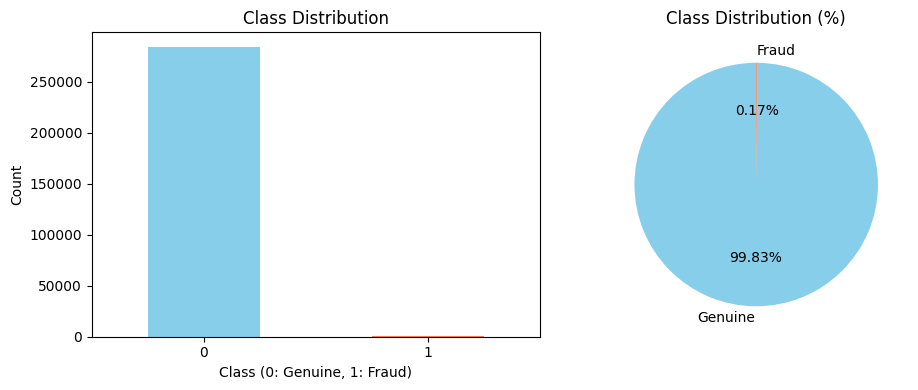


Comprehensive Hyperparameter Tuning
Testing 112 parameter combinations
--------------------------------------------------------------------------------
[1/112] LR: C=0.001, penalty=l1, solver=liblinear, class_weight=None
Training Accuracy: 0.9986
Test Accuracy: 0.9986
Training Precision: 0.8378
Test Precision: 0.7941
Training Recall: 0.2360
Test Recall: 0.2755
Training F1-Score: 0.3683
Test F1-Score: 0.4091
 *** New best F1: 0.4091 ***
[2/112] LR: C=0.001, penalty=l1, solver=liblinear, class_weight=balanced
Training Accuracy: 0.9781
Test Accuracy: 0.9777
Training Precision: 0.0680
Test Precision: 0.0666
Training Recall: 0.9162
Test Recall: 0.9184
Training F1-Score: 0.1265
Test F1-Score: 0.1242
F1: 0.1242
[3/112] LR: C=0.001, penalty=l1, solver=saga, class_weight=None
Training Accuracy: 0.9987
Test Accuracy: 0.9986
Training Precision: 0.8538
Test Precision: 0.7500
Training Recall: 0.2817
Test Recall: 0.3061
Training F1-Score: 0.4237
Test F1-Score: 0.4348
 *** New best F1: 0.4348 ***
[4

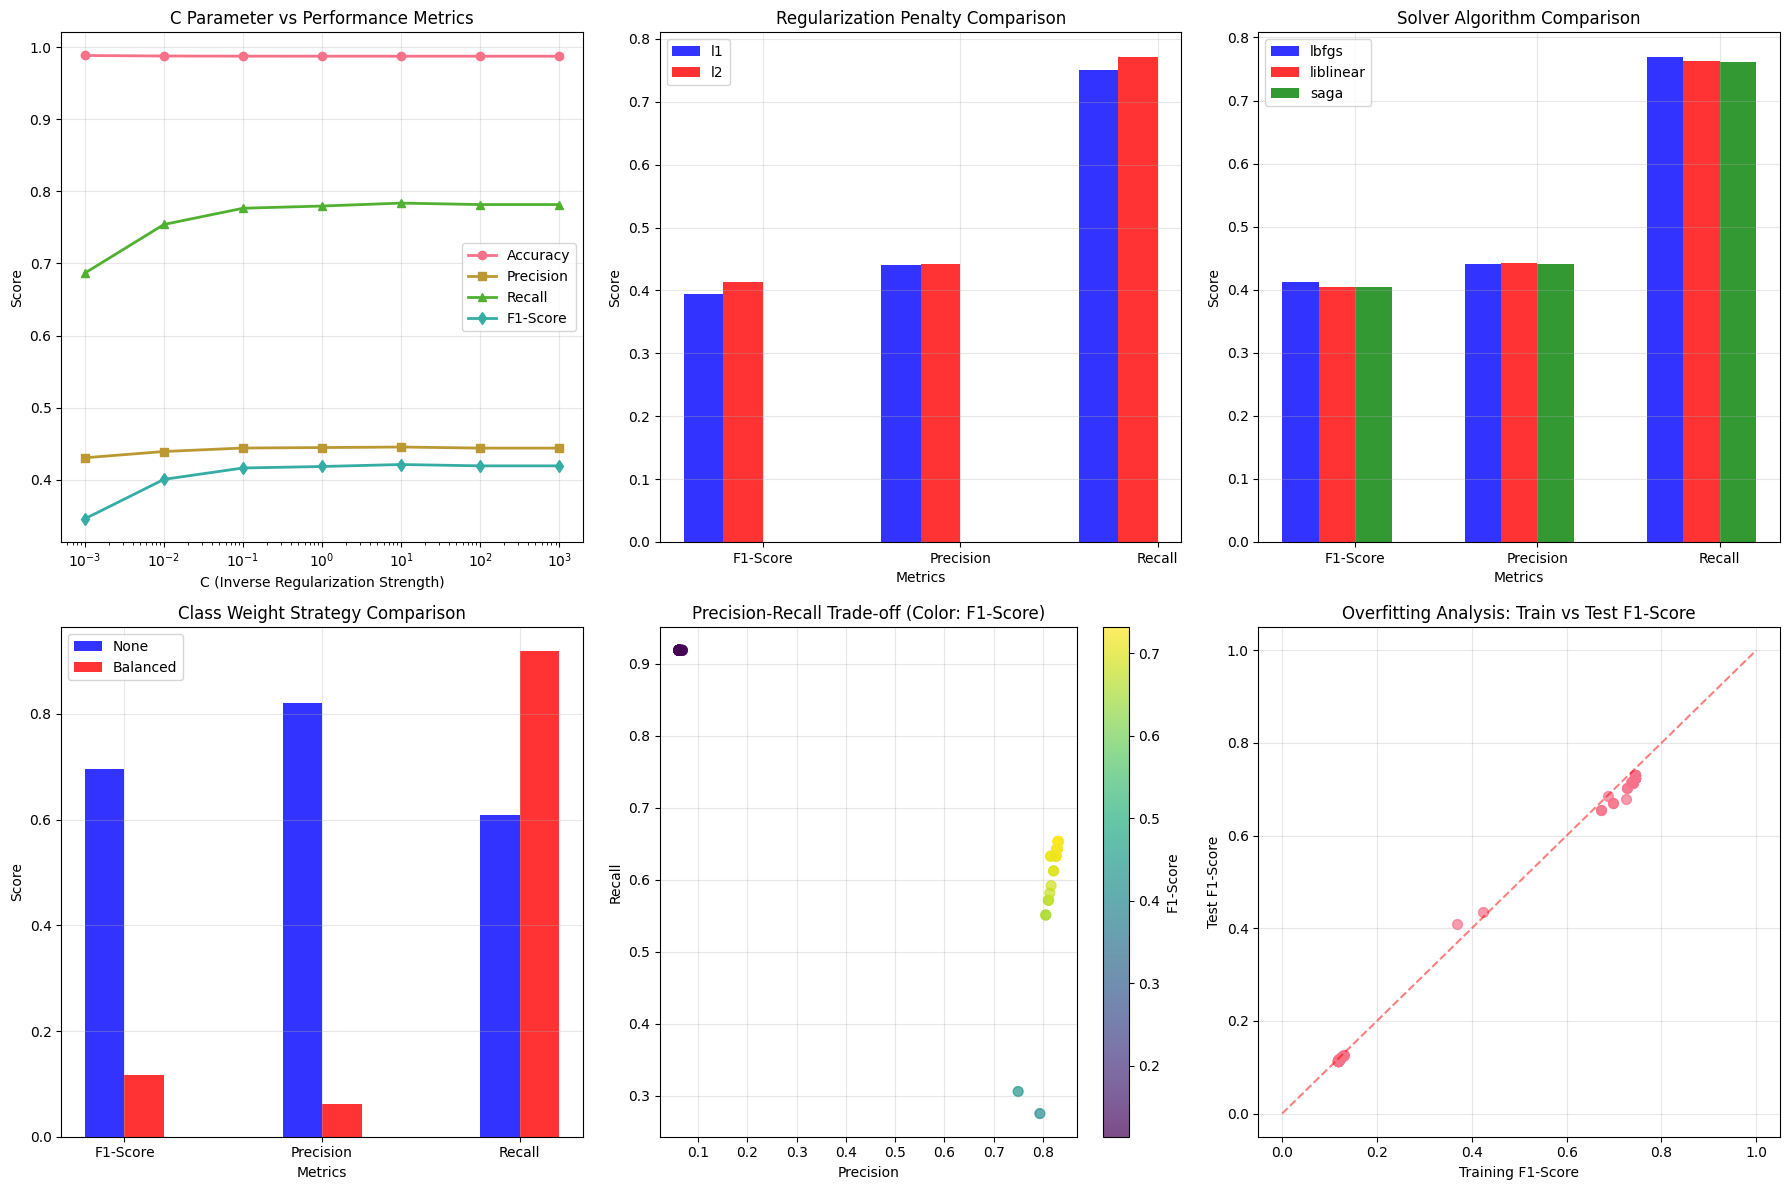

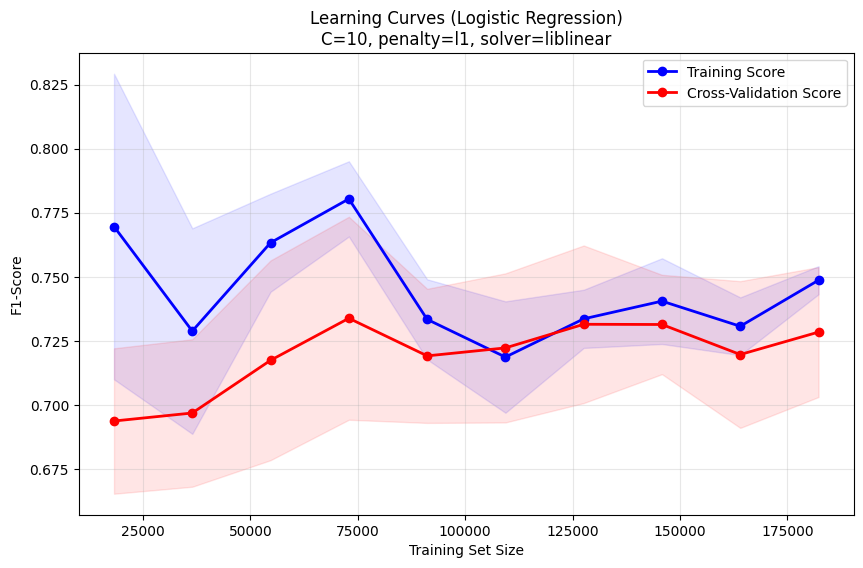

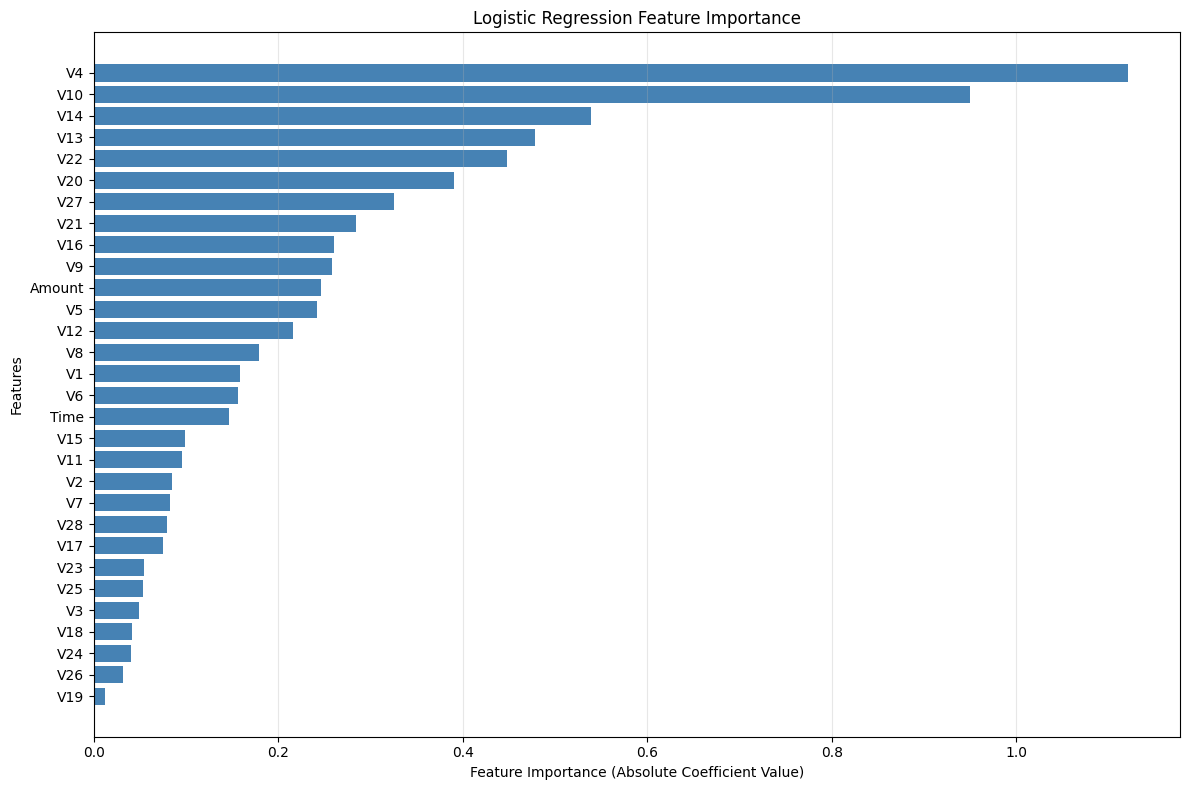


Top 10 Most Important Features:
V9: 0.2582
V16: 0.2602
V21: 0.2837
V27: 0.3253
V20: 0.3905
V22: 0.4479
V13: 0.4780
V14: 0.5388
V10: 0.9502
V4: 1.1214


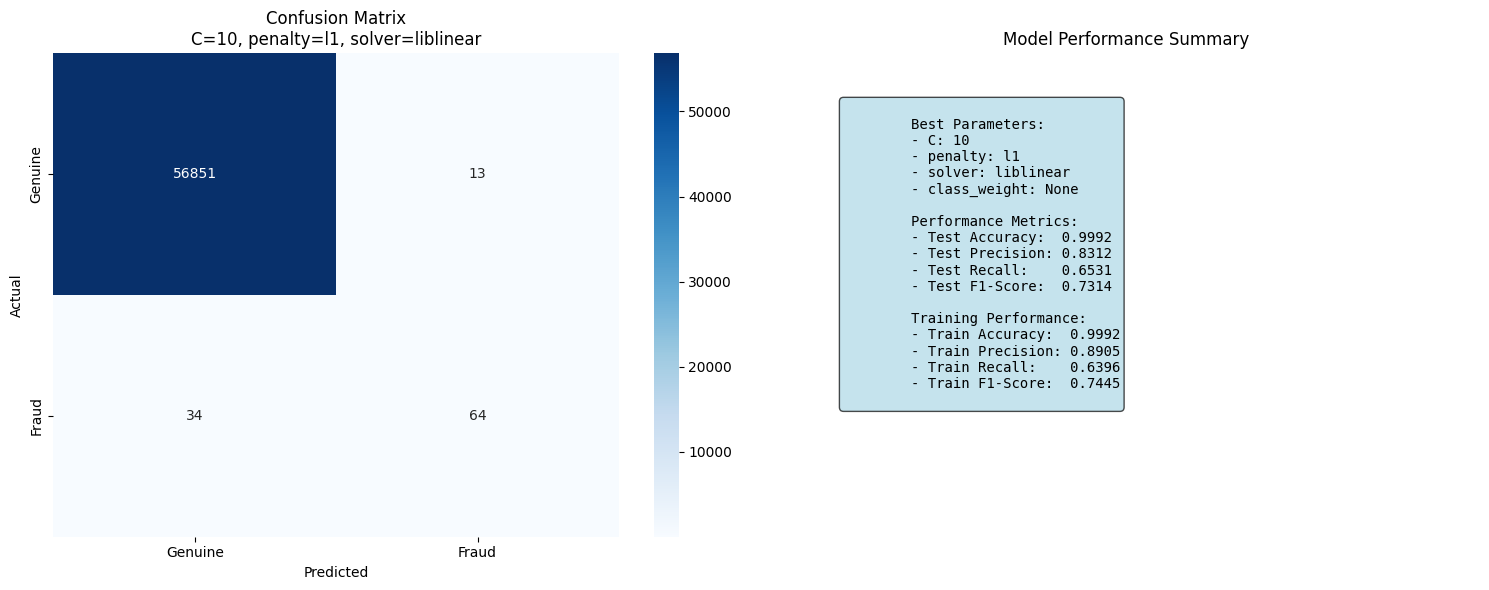

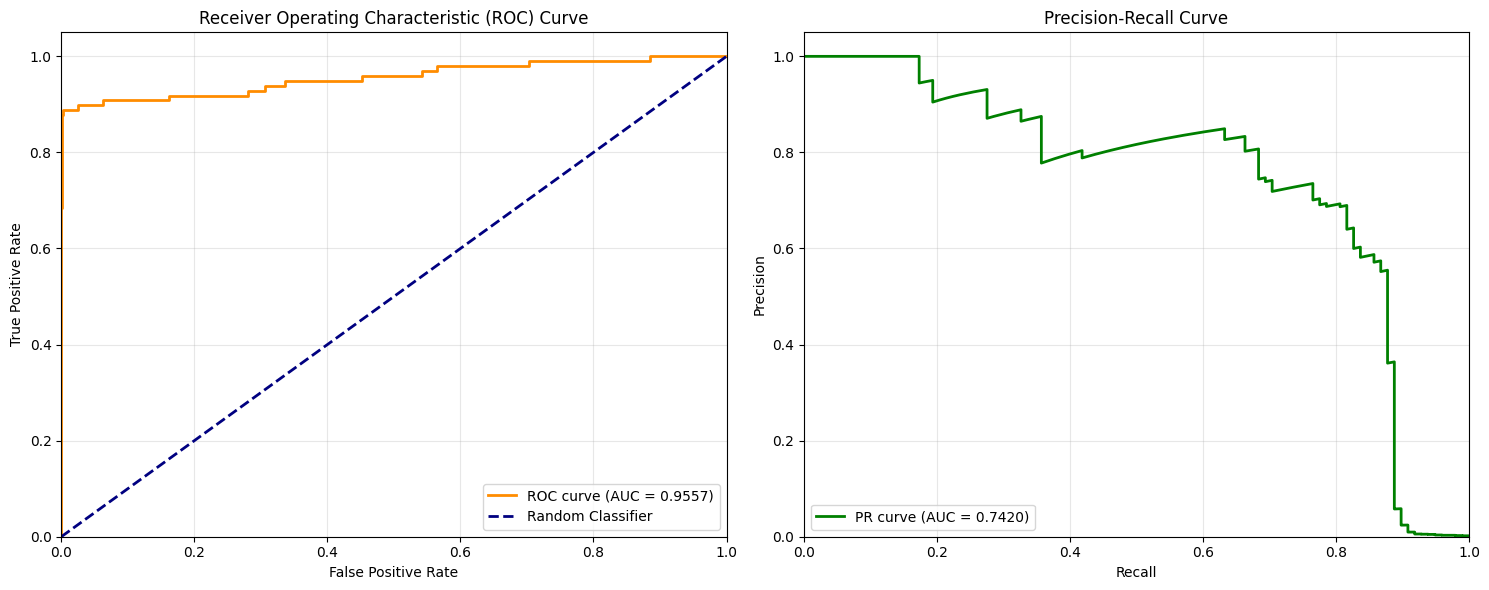


COMPREHENSIVE CLASSIFICATION REPORT
Best Parameters:
  - C: 10
  - penalty: l1
  - solver: liblinear
  - class_weight: None

              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00     56864
       Fraud       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962


Cross-validation Scores (5-fold):
F1:       0.7283 (+/- 0.0507)
Accuracy: 0.9992 (+/- 0.0001)
Precision: 0.8702 (+/- 0.0614)
Recall:    0.6268 (+/- 0.0559)

FINAL MODEL SUMMARY
Best Parameters:
  - C: 10
  - penalty: l1
  - solver: liblinear
  - class_weight: None

Test Performance:
  - Accuracy:  0.9992
  - Precision: 0.8312
  - Recall:    0.6531
  - F1-Score:  0.7314

LOGISTIC REGRESSION PERFORMANCE ANALYSIS
Key Insights:
- Logistic Regression is effective for binary classification problems
- Regularization (C parameter) helps prevent ove

In [3]:
# Cell 3: Run the Complete Pipeline
print("Starting Credit Card Fraud Detection with Logistic Regression...")

# Initialize the fraud detection system
fraud_detector = CreditCardFraudDetectionLR()

# Create directories first
fraud_detector.create_directories()

# Load and preprocess data
fraud_detector.load_data()

# Analyze class imbalance
fraud_detector.analyze_class_imbalance()

# Perform comprehensive hyperparameter tuning
best_params = fraud_detector.hyperparameter_tuning_comprehensive()

# Plot hyperparameter analysis
fraud_detector.plot_hyperparameter_analysis()

# Plot learning curves
fraud_detector.plot_learning_curves()

# Plot feature importance
fraud_detector.plot_feature_importance()

# Plot comprehensive confusion matrix
fraud_detector.plot_confusion_matrix_comprehensive()

# Plot ROC and PR curves
fraud_detector.plot_roc_pr_curves()

# Print comprehensive report
fraud_detector.print_comprehensive_report()

# Print final summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
results = best_params['results']
print(f"Best Parameters:")
print(f"  - C: {best_params['C']}")
print(f"  - penalty: {best_params['penalty']}")
print(f"  - solver: {best_params['solver']}")
print(f"  - class_weight: {best_params['class_weight']}")
print(f"\nTest Performance:")
print(f"  - Accuracy:  {results['test_accuracy']:.4f}")
print(f"  - Precision: {results['test_precision']:.4f}")
print(f"  - Recall:    {results['test_recall']:.4f}")
print(f"  - F1-Score:  {results['test_f1']:.4f}")

print("\n" + "="*60)
print("LOGISTIC REGRESSION PERFORMANCE ANALYSIS")
print("="*60)
print("Key Insights:")
print("- Logistic Regression is effective for binary classification problems")
print("- Regularization (C parameter) helps prevent overfitting")
print("- Different penalties (L1, L2) affect feature selection and model complexity")
print("- Class weighting is crucial for handling imbalanced datasets")
print("- Feature scaling improves convergence and performance")
print("- Solver choice depends on dataset size and regularization type")

print("All steps completed successfully!")  